In [1]:
# LOCATION
from pyfrac.imaging.kirchhoff import Kirchhoff


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


# 2D Attempt

In [3]:
# Velocity Model
nx, nz = 180, 200
dx, dz = 1, 1
x, z = np.arange(nx)*dx, np.arange(nz)*dz

v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

(0.0, 179.0)

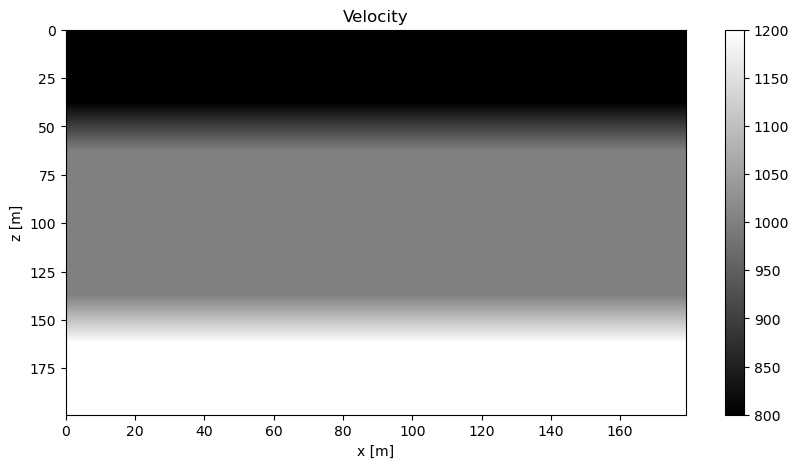

In [4]:
def constantlayers_to_log(vp,interfacedepths,z):
    ''' 
    vp[0] corresponds to velocity of first layer 
    '''
    dz = z[1]
    
    z_old = np.hstack([z[0],interfacedepths,z[-1]])
    f_vp = sp.interpolate.interp1d(z_old, np.hstack([vp,vp[-1]]), kind='previous')
    return f_vp(z)

vp_layers = [800, 1000, 1200]
interfacedepths = [50, 150]

vp_1D  = constantlayers_to_log(vp_layers,interfacedepths,z)
# Smooth
kl = 25
kernel = np.ones(kl) / kl
vp_1D_smth = np.convolve(vp_1D, kernel, mode='same')
vp_1D_smth[:kl//2] = vp_1D[:kl//2]
vp_1D_smth[-kl//2:] = vp_1D[-kl//2:]


vp_3L = np.expand_dims(vp_1D_smth, axis=[0])
vp_3L = vp_3L.repeat(nx,axis=0)
vel=vp_3L

plt.figure(figsize=(10,5))
im = plt.imshow(vp_3L.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('z [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

In [5]:
# RECEIVERS
nr = 11
# Surface
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 1*dz*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# # Borehole
# rz = np.linspace(10*dx, (nx-10)*dx, nr)
# rx = nx//2*dx*np.ones(nr)
# recs = np.vstack((rx, rz))
# dr = recs[1,0]-recs[0,0]




# COLLECT NECESSARY INFORMATION FOR SOURCE LOCATIONS

- Traveltime Tables
- Take-off Angles
- Receiver Angles

In [6]:
# TRAVEL TIME TABLE
trav = Kirchhoff._traveltime_table(z, x, recs, recs, vel, mode='eikonal')[1]

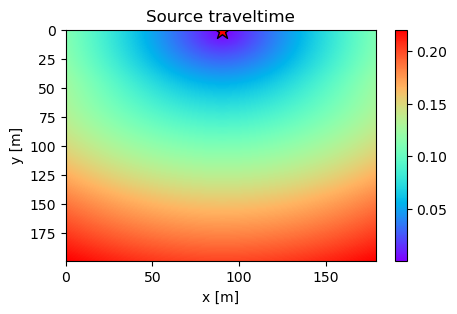

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
im = ax.imshow(trav[:, nr//2].reshape((nx, nz)).T, cmap='rainbow', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(recs[0, nr//2], recs[1, nr//2], marker='*', s=150, c='r', edgecolors='k')
ax.axis('tight')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Source traveltime')
ax.set_ylim(z[-1], z[0])
plt.colorbar(im, ax=ax);

In [27]:
np.mean(trav)

0.1372524535566796

In [8]:
rayangles = Kirchhoff._rayangles_table(z, x, recs, recs, vel, mode='eikonal')

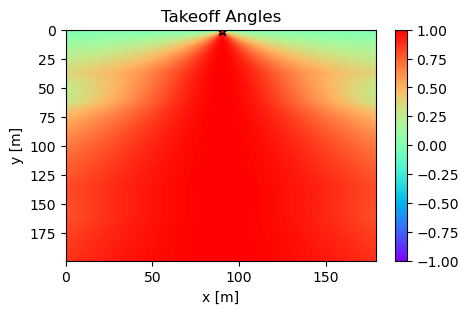

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
im = ax.imshow(rayangles[2][:, nr//2].reshape((nx, nz)).T, cmap='rainbow', 
               extent = (x[0], x[-1], z[-1], z[0]))#, vmin=-np.pi, vmax=np.pi)
ax.scatter(recs[0, nr//2], recs[1, nr//2], marker='*', s=50, c='r', edgecolors='k')
ax.axis('tight')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Takeoff Angles')
ax.set_ylim(z[-1], z[0])
plt.colorbar(im, ax=ax);

In [10]:
# 3d Cosine
# Assume src at 0,0,0
r = (6,5,4)
cosine_theta_x = r[0]/np.sqrt(r[0]**2+r[1]**2+r[2]**2)
cosine_theta_y = r[1]/np.sqrt(r[0]**2+r[1]**2+r[2]**2)
cosine_theta_z = r[2]/np.sqrt(r[0]**2+r[1]**2+r[2]**2)

In [11]:
np.arccos(cosine_theta_x)

0.8178885561654512

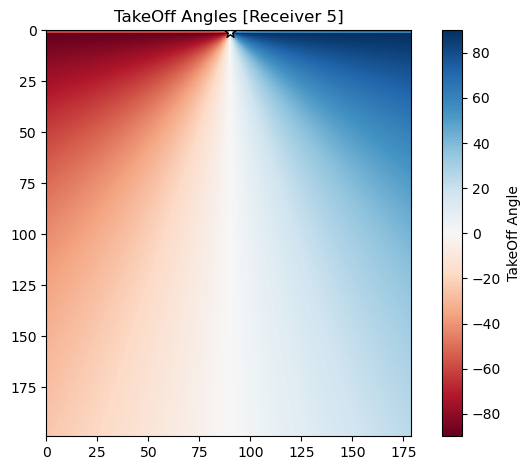

In [12]:
# GEOMETRIC VERSION - HOMOGENEOUS ASSUMPTION
rec_index = 5
rx,rz = recs[0, rec_index], recs[1, rec_index]

s_locs_x, s_locs_z = np.meshgrid(x,z)
delta_x = s_locs_x - rx
delta_z = s_locs_z - rz
takeoff = np.rad2deg(np.arctan(delta_x/delta_z))
arrival = np.rad2deg(np.arctan(delta_x/delta_z))

fig,ax = plt.subplots(1,1)
c = ax.imshow(arrival, vmin=-90, vmax=90, cmap='RdBu', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(recs[0, rec_index], recs[1, rec_index], marker='*', s=75, c='w', edgecolors='k')

fig.colorbar(c, label='TakeOff Angle')
ax.set_title('TakeOff Angles [Receiver %i]'%rec_index)
fig.tight_layout()

In [13]:
# GEOMETRIC VERSION - HOMOGENEOUS ASSUMPTION
takeoff_ana = np.zeros((nr, nx, nz))
for irec in range(nr):
    rx,rz = recs[0, irec], recs[1, irec]
    
    s_locs_x, s_locs_z = np.meshgrid(x,z)
    delta_x = s_locs_x.T - rx
    delta_z = s_locs_z.T - rz
    takeoff_ana[irec]= np.rad2deg(np.arctan(delta_x/delta_z))

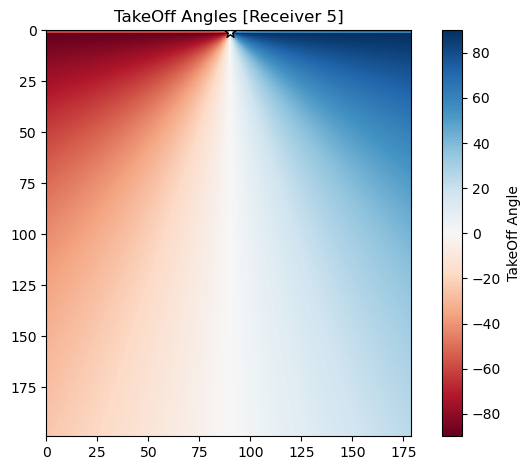

In [14]:
rec_index = 5

fig,ax = plt.subplots(1,1)
c = ax.imshow(takeoff_ana[rec_index].T, vmin=-90, vmax=90, cmap='RdBu', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(recs[0, rec_index], recs[1, rec_index], marker='*', s=75, c='w', edgecolors='k')

fig.colorbar(c, label='TakeOff Angle')
ax.set_title('TakeOff Angles [Receiver %i]'%rec_index)
fig.tight_layout()

# TAKE-OFF ANGLES
To compute the take off angle I can simply slice the TTTable array to take each receiver, then compute the gradient (nb the gradient of the TT contours indicates the direction of travel). 

In 2D, theta = arctan(grad_Tx/grad_Tz)


In [15]:
# 2D Take-off angles
TTT_full = trav.reshape((nx,nz,nr)).transpose([2,0,1])
print('TTTable dimensions:',TTT_full.shape)
# Take gradients in x and z
dTdx_full,dTdz_full =  np.gradient(TTT_full, axis=[1,2])
# Compute the angle 
theta_takeoff_rads = np.arctan(dTdx_full/dTdz_full)
theta_takeoff_degs = np.rad2deg(theta_takeoff_rads)

TTTable dimensions: (11, 180, 200)


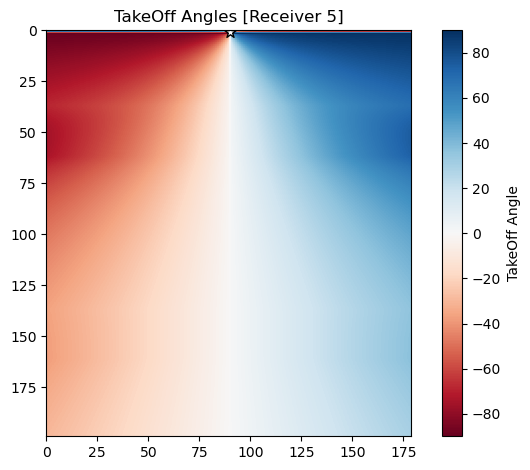

In [16]:
rec_index = 5

fig,ax = plt.subplots(1,1)
c = ax.imshow(theta_takeoff_degs[rec_index].T, vmin=-90, vmax=90, cmap='RdBu', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(recs[0, rec_index], recs[1, rec_index], marker='*', s=75, c='w', edgecolors='k')

fig.colorbar(c, label='TakeOff Angle')
ax.set_title('TakeOff Angles [Receiver %i]'%rec_index)
fig.tight_layout()

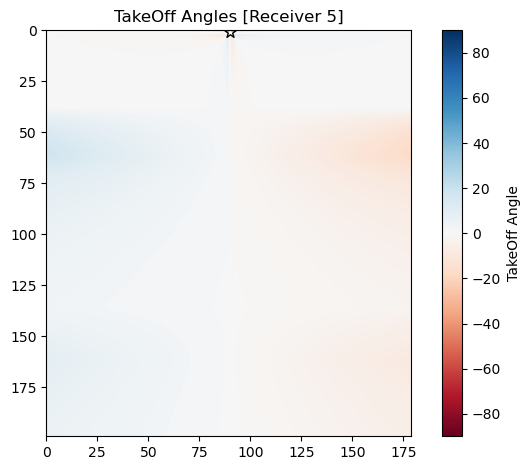

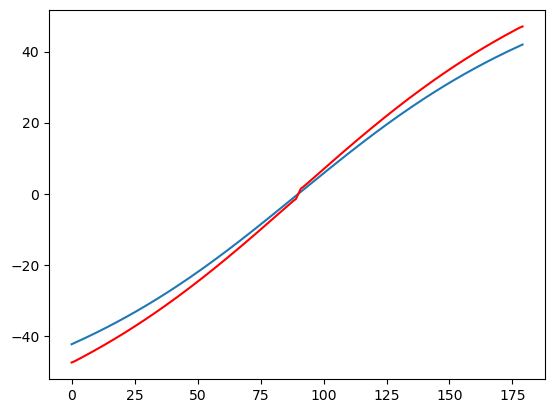

In [17]:
rec_index = 5

fig,ax = plt.subplots(1,1)
c = ax.imshow(takeoff-theta_takeoff_degs[rec_index].T, vmin=-90, vmax=90, cmap='RdBu', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(recs[0, rec_index], recs[1, rec_index], marker='*', s=75, c='w', edgecolors='k')

fig.colorbar(c, label='TakeOff Angle')
ax.set_title('TakeOff Angles [Receiver %i]'%rec_index)
fig.tight_layout()

plt.figure()
plt.plot(takeoff[nz//2])
plt.plot(theta_takeoff_degs[rec_index][:, nz//2], 'r')

# ARRIVAL ANGLES
Because I want to use eikonal TTs (as opposed to shooting rays) and I don't want to "shoot" from every subsurface point as that will be super expensive for a large area of interest, then we got to get creative. 
1. For each subsurface point take vector of tts to all receivers (receivers assumed line with constant z)
2. Take difference along the vector (pseudo-grad)
3. The gradient is equivalent to the surface slowness which is equal to sin(theta)/vel
4. theta = arcsin ( dT/dx $\cdot vel)

In [18]:
theta_arrival_rads = np.zeros_like(theta_takeoff_rads)

In [19]:
x_gd, z_gd = np.meshgrid(x/dx,z/dz)
x_gd = x_gd.ravel().astype(int)
z_gd = z_gd.ravel().astype(int)
x_gd.shape

(36000,)

In [20]:
TTT_full.shape

(11, 180, 200)

In [21]:
# LINE OF X
theta_arrival_rads = np.zeros_like(theta_takeoff_rads)
x_gd, z_gd = np.meshgrid(x/dx,z/dz)
x_gd = x_gd.ravel().astype(int)
z_gd = z_gd.ravel().astype(int)

for a,b in zip(x_gd, z_gd):
    dz_sign = np.sign(recs[1]-b*dz)
    TTT_singloc = TTT_full[:,a,b]
    dTdx_singloc_grad = np.gradient(TTT_singloc, dr)
    theta_arrival_rads[:,a,b] = dz_sign * np.arcsin(dTdx_singloc_grad * vel[0,0]) # assume lateral homo surface
theta_arrival_degs = np.rad2deg(theta_arrival_rads)

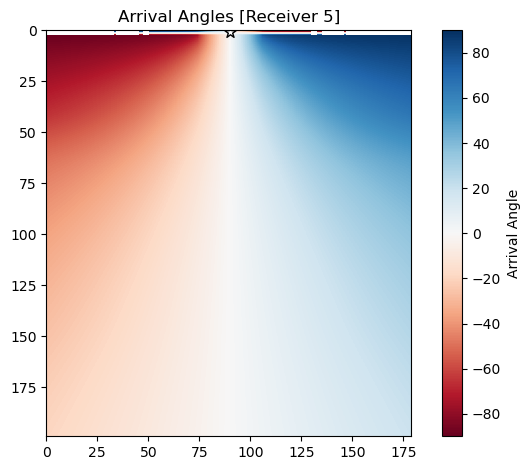

In [22]:
rec_index = 5

fig,ax = plt.subplots(1,1)
c = ax.imshow(theta_arrival_degs[rec_index].T, vmin=-90, vmax=90, cmap='RdBu', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(recs[0, rec_index], recs[1, rec_index], marker='*', s=75, c='w', edgecolors='k')

fig.colorbar(c, label='Arrival Angle')
ax.set_title('Arrival Angles [Receiver %i]'%rec_index)
fig.tight_layout()

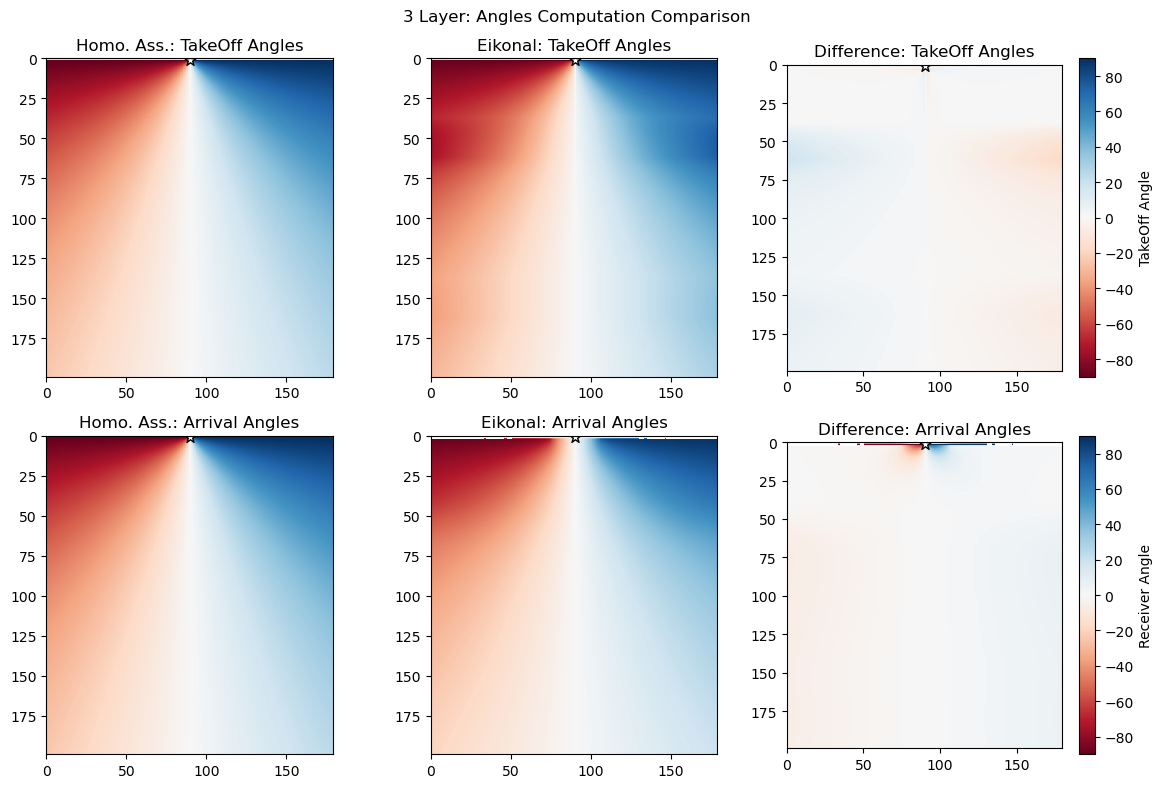

In [23]:
fig, [ax_to, ax_ar] = plt.subplots(2,3,figsize=[12,8])

ax_to[0].imshow(takeoff_ana[rec_index].T, vmin=-90, vmax=90, 
                      cmap='RdBu', extent = (x[0], x[-1], z[-1], z[0]))
ax_to[1].imshow(theta_takeoff_degs[rec_index].T, vmin=-90, vmax=90, 
                      cmap='RdBu', extent = (x[0], x[-1], z[-1], z[0]))
at = ax_to[2].imshow(takeoff_ana[rec_index].T-theta_takeoff_degs[rec_index].T, vmin=-90, vmax=90, 
                      cmap='RdBu', extent = (x[0], x[-1], z[-1], z[0]))

ax_ar[0].imshow(takeoff_ana[rec_index].T, vmin=-90, vmax=90, 
                      cmap='RdBu', extent = (x[0], x[-1], z[-1], z[0]))
ax_ar[1].imshow(theta_arrival_degs[rec_index].T, vmin=-90, vmax=90, 
                      cmap='RdBu', extent = (x[0], x[-1], z[-1], z[0]))
ar = ax_ar[2].imshow(takeoff_ana[rec_index].T-theta_arrival_degs[rec_index].T, vmin=-90, vmax=90, 
                      cmap='RdBu', extent = (x[0], x[-1], z[-1], z[0]))

for ax in ax_to: ax.scatter(recs[0, rec_index], recs[1, rec_index], marker='*', s=75, c='w', edgecolors='k')
for ax in ax_ar: ax.scatter(recs[0, rec_index], recs[1, rec_index], marker='*', s=75, c='w', edgecolors='k')

fig.colorbar(at, label='TakeOff Angle')
fig.colorbar(ar, label='Receiver Angle')


ax_to[0].set_title('Analytical: TakeOff Angles')
ax_to[1].set_title('Eikonal: TakeOff Angles')
ax_to[2].set_title('Difference: TakeOff Angles')

ax_ar[0].set_title('Analytical: Arrival Angles')
ax_ar[1].set_title('Eikonal: Arrival Angles')
ax_ar[2].set_title('Difference: Arrival Angles')

# fig.suptitle('Homo: Angles Computation Comparison')


ax_to[0].set_title('Homo. Ass.: TakeOff Angles')
ax_ar[0].set_title('Homo. Ass.: Arrival Angles')
fig.suptitle('3 Layer: Angles Computation Comparison')

fig.tight_layout()

In [24]:
TTT_singloc = TTT_full[:,nz//2,nx//2]
dTdx_singloc_grad = np.gradient(TTT_singloc, dr)
theta_arrival_rads = np.arcsin(dTdx_singloc_grad * vel[0,0]) # assume lateral homo surface
theta_arrival_degs = np.rad2deg(theta_arrival_rads)

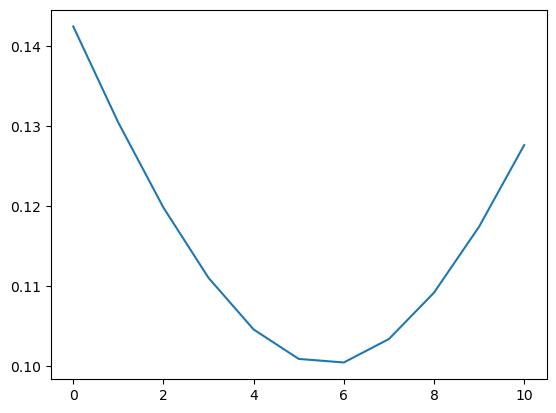

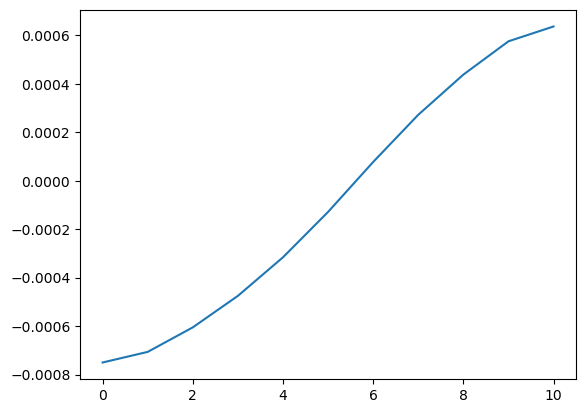

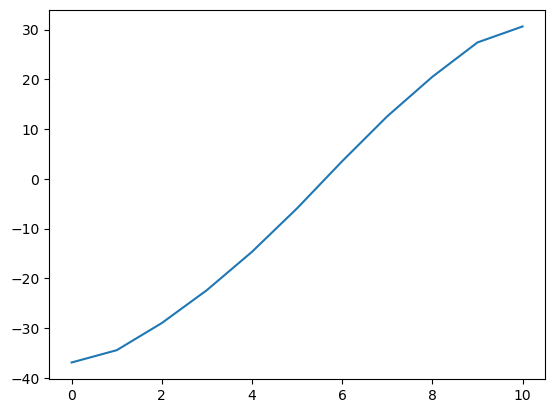

In [25]:
plt.figure()
plt.plot(TTT_singloc)

plt.figure()
plt.plot(dTdx_singloc_grad)


plt.figure()
plt.plot(theta_arrival_degs)